# Import Libraries

In [1]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
from google.colab import drive
from PIL import Image
import math
from tensorflow.keras.layers import ReLU

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input,LeakyReLU, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal, GlorotNormal
from tensorflow.keras.utils import Sequence

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
# Connect with goole drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install Kaggle

!pip install kaggle

In [4]:
# Make directory

!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
# Locate API key

!cp /content/drive/MyDrive/hck021/kaggle.json ~/.kaggle/

In [6]:
# Download dataset

!kaggle datasets download -d yusufemir/lemon-quality-dataset

Dataset URL: https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset
License(s): CC0-1.0
lemon-quality-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# Unzip

!unzip -q ./lemon-quality-dataset.zip

replace lemon_dataset/.git/COMMIT_EDITMSG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
# Upgrade tensorflow version

!pip install --upgrade "tensorflow<2.16" "tf-keras<2.16"

In [9]:
# Install pillow

!pip install pillow

In [10]:
# Assign variable for every folder

good_files = glob.glob('/content/lemon_dataset/good_quality/*')
bad_files = glob.glob('/content/lemon_dataset/bad_quality/*')

good_files.sort()
bad_files.sort()

print(f'good_files : {good_files}\n')
print(f'bad_files : {bad_files}')

good_files : ['/content/lemon_dataset/good_quality/good_quality_0.jpg', '/content/lemon_dataset/good_quality/good_quality_1.jpg', '/content/lemon_dataset/good_quality/good_quality_10.jpg', '/content/lemon_dataset/good_quality/good_quality_100.jpg', '/content/lemon_dataset/good_quality/good_quality_1000.jpg', '/content/lemon_dataset/good_quality/good_quality_1001.jpg', '/content/lemon_dataset/good_quality/good_quality_1002.jpg', '/content/lemon_dataset/good_quality/good_quality_1003.jpg', '/content/lemon_dataset/good_quality/good_quality_1004.jpg', '/content/lemon_dataset/good_quality/good_quality_1005.jpg', '/content/lemon_dataset/good_quality/good_quality_1006.jpg', '/content/lemon_dataset/good_quality/good_quality_1007.jpg', '/content/lemon_dataset/good_quality/good_quality_1008.jpg', '/content/lemon_dataset/good_quality/good_quality_1009.jpg', '/content/lemon_dataset/good_quality/good_quality_101.jpg', '/content/lemon_dataset/good_quality/good_quality_1010.jpg', '/content/lemon_data

In [11]:
# Create dataframe

all_files = good_files + bad_files
labels = ['good' for i in range(len(good_files))] + ['bad' for i in range(len(bad_files))]
img_df = pd.DataFrame({'images':all_files, 'quality':labels})
img_df = img_df.sample(len(img_df)).reset_index(drop=True)
img_df

,images,quality
0,/content/lemon_dataset/good_quality/good_quali...,good
1,/content/lemon_dataset/good_quality/good_quali...,good
2,/content/lemon_dataset/bad_quality/bad_quality...,bad
3,/content/lemon_dataset/good_quality/good_quali...,good
4,/content/lemon_dataset/bad_quality/bad_quality...,bad
...,...,...
2071,/content/lemon_dataset/good_quality/good_quali...,good
2072,/content/lemon_dataset/good_quality/good_quali...,good
2073,/content/lemon_dataset/good_quality/good_quali...,good
2074,/content/lemon_dataset/bad_quality/bad_quality...,bad


# Feature Engineering

## Preprocessing

In [14]:
# Split dataframe

X, X_test, y, y_test = train_test_split(img_df['images'], img_df['quality'], test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=0)

I used only two folders, 'good_quality' and 'bad_quality,' and then split them into three different datasets: a training set, a validation set, and a test set.

In [15]:
# Concat for every dataset type

train_set = pd.concat([X_train, y_train], axis=1)
val_set = pd.concat([X_val, y_val], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

Concatenate each set to perform a validation split afterward.

In [16]:
# Validation split

imgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                        rotation_range=20,
                                                        zoom_range=0.05,
                                                        width_shift_range=0.05,
                                                        height_shift_range=0.05,
                                                        shear_range=0.05,
                                                        horizontal_flip=True,
                                                        validation_split=0.4)

train = imgen.flow_from_dataframe(train_set,
                                  x_col='images',
                                  y_col='quality',
                                  target_size=(224,224),
                                  class_mode='binary',
                                  subset='training', color_mode='rgb',
                                  shuffle=True,
                                  batch_size=64,
                                  seed=2)
val = imgen.flow_from_dataframe(val_set,
                                  x_col='images',
                                  y_col='quality',
                                  target_size=(224,224),
                                  class_mode='binary',
                                  subset='validation', color_mode='rgb',
                                  shuffle=True,
                                  batch_size=64,
                                  seed=2)

imgen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test = imgen2.flow_from_dataframe(test_set,
                                  x_col='images',
                                  y_col='quality',
                                  target_size=(224,224),
                                  class_mode='binary', color_mode='rgb',
                                  shuffle=True,
                                  batch_size=64,
                                  seed=2)

Found 672 validated image filenames belonging to 2 classes.
Found 299 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.


In this Image Data Generator, I have already included some augmentations, such as rescaling, rotation, zoom range, and horizontal flipping.

In [17]:
# Show labels

print(train.class_indices)

{'bad': 0, 'good': 1}


# ANN Training (Sequential API)

## Model Definition

In [18]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [19]:
# Create the Sequential model
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

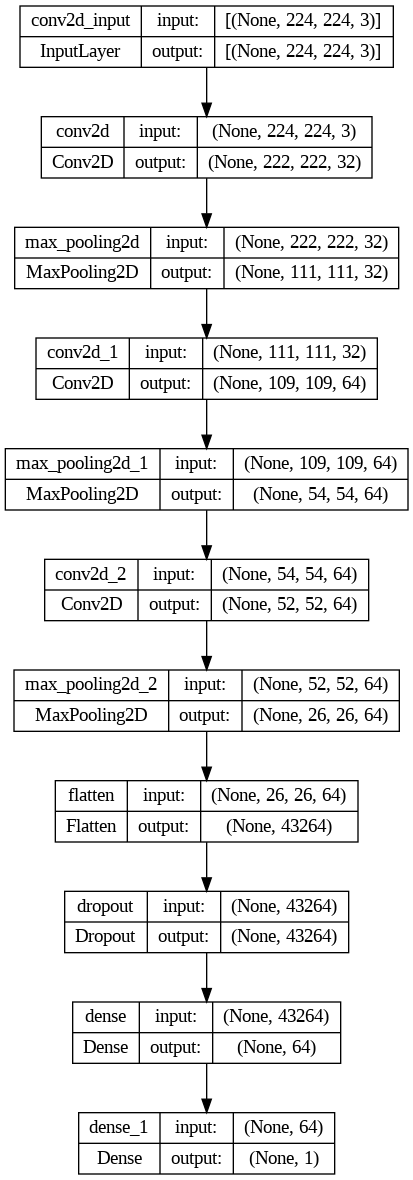

In [20]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

<h4>Plot model :</h4>

1. Add 3 Convolutional Layers, each with 32, 64, 64 filters of size 3x3 and ReLU activation. The first layer also specifies the input shape as 224x224 pixels with 3 channels (RGB). Each convolutional layer is followed by a max pooling layer with a pool size of 2x2.

2. Flatten Layer: Flattens the 3D feature maps from the last convolutional layer into a 1D vector, which will serve as the input to the fully connected layers.

3. Dropout Layer: Adds a dropout layer with a 50% dropout rate to randomly deactivate neurons during training, helping to reduce overfitting.

4. Dense Layer: Adds a dense layer with 64 neurons and ReLU activation.

5. Output Layer: Adds the output layer with 1 neuron and a sigmoid activation function, suitable for binary classification.

6. Model Compilation: Specifies binary cross-entropy as the loss function, uses the Adam optimizer for adaptive learning, and monitors accuracy as a metric during training and evaluation.

## Model Training

In [21]:
# Training

history = model.fit(train, epochs=20, validation_data=val, batch_size=10)

Epoch 1/20
11/11 [==============================] - 33s 2s/step - loss: 0.7696 - accuracy: 0.5982 - val_loss: 0.5670 - val_accuracy: 0.7826
Epoch 2/20
11/11 [==============================] - 12s 1s/step - loss: 0.5303 - accuracy: 0.7500 - val_loss: 0.4750 - val_accuracy: 0.7993
Epoch 3/20
11/11 [==============================] - 12s 1s/step - loss: 0.4464 - accuracy: 0.7976 - val_loss: 0.4419 - val_accuracy: 0.7692
Epoch 4/20
11/11 [==============================] - 12s 1s/step - loss: 0.4155 - accuracy: 0.8140 - val_loss: 0.3812 - val_accuracy: 0.8428
Epoch 5/20
11/11 [==============================] - 12s 1s/step - loss: 0.3882 - accuracy: 0.8333 - val_loss: 0.3898 - val_accuracy: 0.8528
Epoch 6/20
11/11 [==============================] - 13s 1s/step - loss: 0.3528 - accuracy: 0.8616 - val_loss: 0.2925 - val_accuracy: 0.8829
Epoch 7/20
11/11 [==============================] - 13s 1s/step - loss: 0.3096 - accuracy: 0.8750 - val_loss: 0.7454 - val_accuracy: 0.7023
Epoch 8/20
11/11 [==

## Model Evaluation

<function matplotlib.pyplot.show(close=None, block=None)>

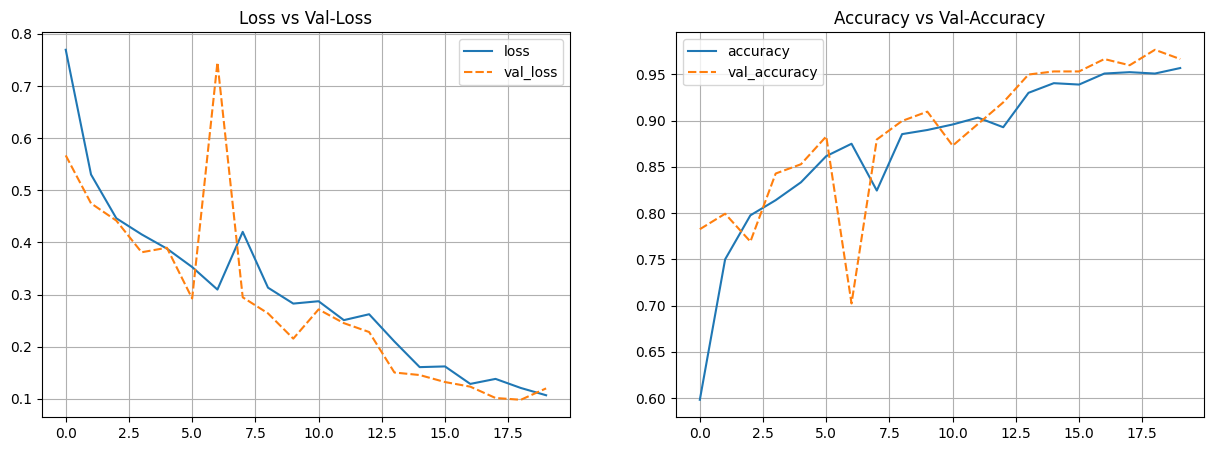

In [22]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show

In [23]:
# Get the probability of the positive class
y_pred_prob = model.predict_generator(test)

# Apply threshold to convert probabilities to binary class labels (0 or 1)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Display Classification Report
print(classification_report(test.classes, y_pred_class, target_names=np.array(list(train.class_indices.keys()))))

              precision    recall  f1-score   support

         bad       0.46      0.50      0.48       101
        good       0.49      0.46      0.47       107

    accuracy                           0.48       208
   macro avg       0.48      0.48      0.48       208
weighted avg       0.48      0.48      0.48       208



<h4>Evaluation Model</h4>

1. Model training is conducted for 20 epochs with a batch size of 10, taking approximately 13 seconds per epoch.
2. The training results show no difference between training and validation accuracy, both achieving 0.95, with losses of 0.12 and 0.13, respectively.
3. The model appears to be overfitting; despite high accuracy on both the training and validation sets, its performance on the test set is significantly lower, with an accuracy score of only 0.54.

# ANN Improvement(Squential API)

## Preprocessing

In [24]:
# Assign function

def rgb_to_cmyk(image):
    '''
    This function returns a CMYK image with four channels, where each pixel contains the cyan, magenta, yellow, and black components.
    '''
    rgb = image / 255.0  # Normalize RGB values to [0, 1]
    k = 1 - np.max(rgb, axis=2)
    c = (1 - rgb[..., 0] - k) / (1 - k + 1e-6)
    m = (1 - rgb[..., 1] - k) / (1 - k + 1e-6)
    y = (1 - rgb[..., 2] - k) / (1 - k + 1e-6)
    cmyk = np.stack([c, m, y, k], axis=2)
    return cmyk

def cmyk_data_generator(generator, rgb_to_cmyk_func):
    '''
    It will automatically handle the RGB-to-CMYK conversion batch by batch.
    '''
    for batch in generator:
        images, labels = batch
        cmyk_images = np.array([rgb_to_cmyk_func(image) for image in images])
        yield cmyk_images, labels

In [25]:
# Change from rgb into cmyk

train_cmyk = cmyk_data_generator(train, rgb_to_cmyk)
val_cmyk = cmyk_data_generator(val, rgb_to_cmyk)
test_cmyk = cmyk_data_generator(test, rgb_to_cmyk)

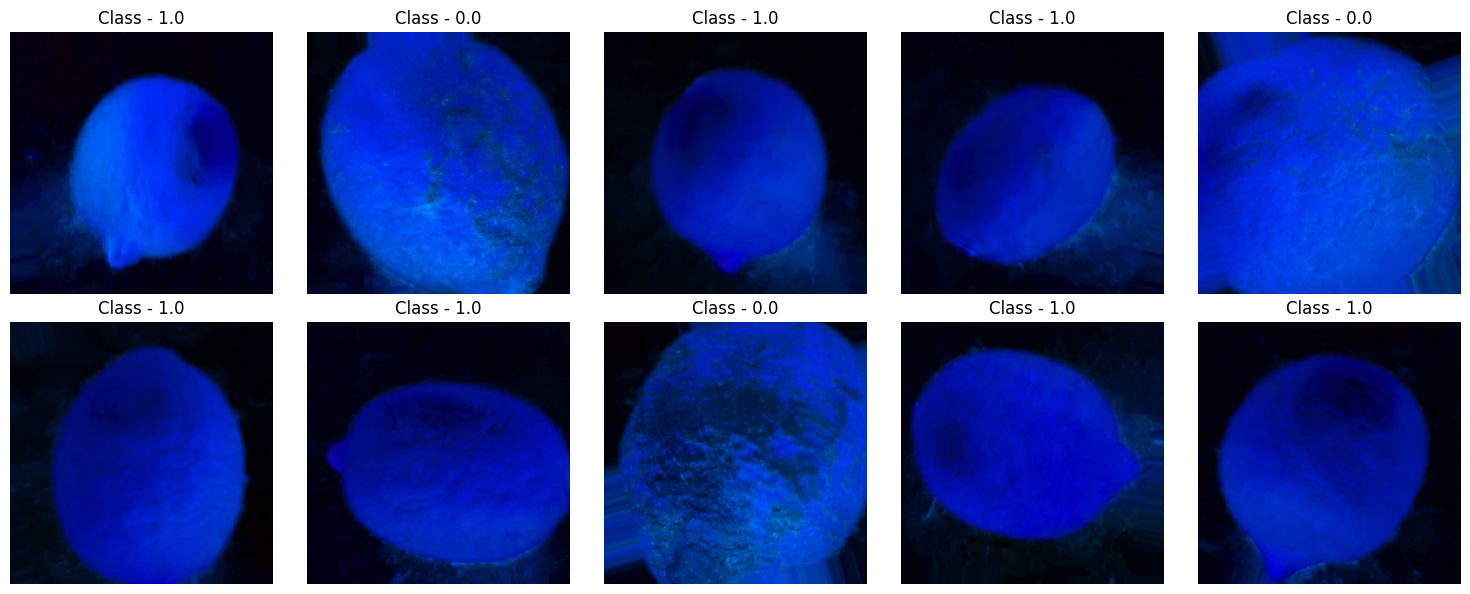

In [26]:
images, labels = next(train_cmyk)

# Display a few images from the batch
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(2):
    for j in range(5):
        img_idx = i * 5 + j
        ax[i, j].imshow(images[img_idx])
        ax[i, j].set_title(f'Class - {labels[img_idx]}')
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()

<h4>Improvement Preprocessing</h4>

1. We define two functions, rgb_to_cmyk and cmyk_data_generator, to convert images in the training, validation, and test sets to the CMYK color space.
2. After defining these functions, we use them to convert the original RGB images to CMYK.
3. We display the results after converting the images to CMYK along with their corresponding labels.

## Model Definition

### My Own Model

In [27]:
# Improved Sequential API Model
model_improve = Sequential()

# First Convolutional Block
model_improve.add(Conv2D(32, (3,3), kernel_initializer=HeNormal(), input_shape=(224,224,4)))
model_improve.add(ReLU())
model_improve.add(BatchNormalization())
model_improve.add(MaxPooling2D(2,2))
model_improve.add(Dropout(0.2))

# Second Convolutional Block
model_improve.add(Conv2D(64, (3,3), kernel_initializer=HeNormal()))
model_improve.add(ReLU())
model_improve.add(BatchNormalization())
model_improve.add(MaxPooling2D(2,2))
model_improve.add(Dropout(0.25))

# Third Convolutional Block
model_improve.add(Conv2D(128, (3,3), kernel_initializer=HeNormal()))
model_improve.add(ReLU())
model_improve.add(BatchNormalization())
model_improve.add(MaxPooling2D(2,2))
model_improve.add(Dropout(0.3))

# Fourth Convolutional Block
model_improve.add(Conv2D(256, (3,3), kernel_initializer=HeNormal()))
model_improve.add(ReLU())
model_improve.add(BatchNormalization())
model_improve.add(MaxPooling2D(2,2))
model_improve.add(Dropout(0.3))

# Flattening and Fully Connected Layers
model_improve.add(Flatten())
model_improve.add(Dense(128, kernel_initializer=HeNormal()))
model_improve.add(ReLU())
model_improve.add(BatchNormalization())
model_improve.add(Dropout(0.4))

# Output Layer
model_improve.add(Dense(1, activation='sigmoid', kernel_initializer=GlorotNormal()))

# Compile the Model with a lower learning rate
optimizer = Adam(learning_rate=1e-4)
model_improve.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Summary of the Model
model_improve.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      1184      
                                                                 
 re_lu (ReLU)                (None, 222, 222, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)     

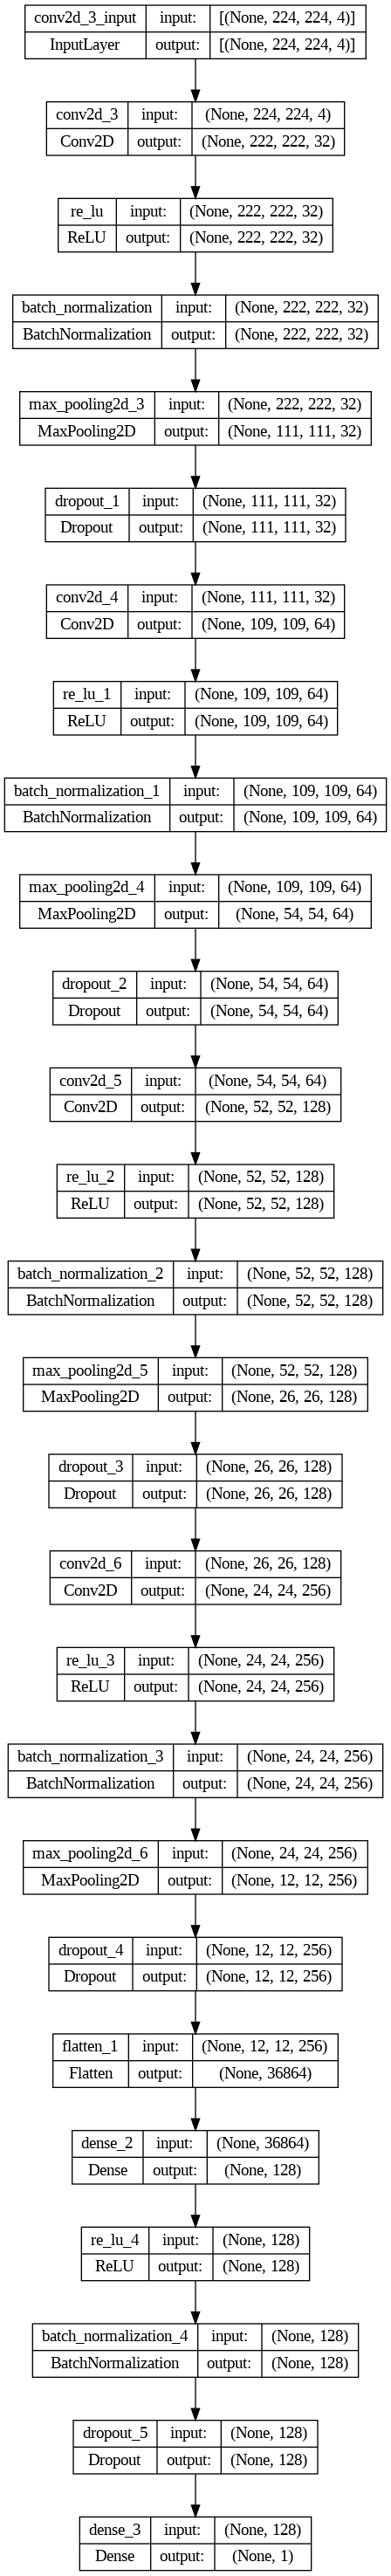

In [28]:
# Plot layers

tf.keras.utils.plot_model(model_improve, show_shapes=True)

<h4>Plot Improvement Model</h4>

1. Convolutional Layers: Adds 4 convolutional layers with 32, 64, 128, and 256 filters, each with a 3x3 filter size and ReLU activation. The first layer also specifies the input shape as 224x224 pixels with 4 channels (CMYK). Each convolutional layer is followed by a max pooling layer with a pool size of 2x2. Batch normalization is applied after each convolution to standardize inputs and improve convergence, followed by a dropout layer to reduce overfitting by randomly deactivating neurons.

2. Flatten Layer and Fully Connected Layer: Flattens the 3D feature maps from the last convolutional layer into a 1D vector, which serves as input to the fully connected layers. Adds a dense layer with 128 neurons, initializing weights using the He Normal method, and a dropout layer to reduce overfitting by deactivating neurons randomly.

3. Output Layer: Adds the output layer with 1 neuron and a sigmoid activation function, using the Glorot (Xavier) initializer to initialize weights, making it suitable for binary classification.

4. Model Compilation: Specifies binary cross-entropy as the loss function and uses the Adam optimizer with a lower learning rate (1e-4) to make smaller, adaptive adjustments to the weights, enhancing model stability and performance. Monitors accuracy as a metric during training and evaluation.



### Transfer Learning

In [29]:
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [30]:
# Create Sequential API for Transfer Learning

model_tl = Sequential()
model_tl.add(pretrained_model)
model_tl.add(Flatten())
model_tl.add(Dense(512, activation='relu'))
model_tl.add(Dense(1, activation='sigmoid'))

# Compile

model_tl.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model_tl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 27560769 (105.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


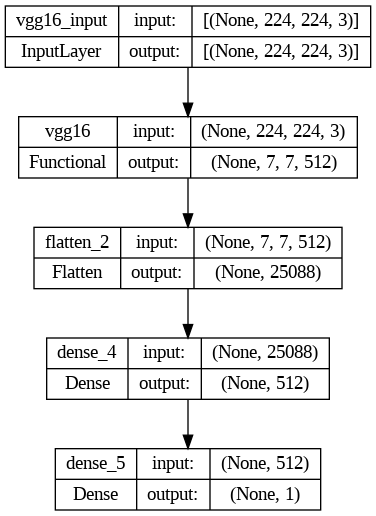

In [31]:
# Plot layers

tf.keras.utils.plot_model(model_tl, show_shapes=True)

<h4>Plot Transfer Learning Model</h4>

1. Load Pre-trained Model (VGG16): Loads the VGG16 model pre-trained on the ImageNet dataset to leverage its learned features. Uses pre-trained weights from ImageNet and excludes the fully connected layers (top of the model), keeping only the convolutional base. Sets the input shape to 224x224 pixels with 3 channels (RGB), matching the expected input size for VGG16.

2. Flatten Layer and Fully Connected Layer: Flattens the 3D feature maps from the last convolutional layer into a 1D vector, serving as input to the fully connected layers. Adds a dense layer with 512 neurons and ReLU activation to learn high-level features.

3. Output Layer: Adds the output layer with 1 neuron and a sigmoid activation function for binary classification.

4. Model Compilation: Specifies binary cross-entropy as the loss function, uses the Adam optimizer for adaptive learning, and monitors accuracy as a metric during training and evaluation.

## Model Training

### Training my own model

In [32]:
# Training

num_train_samples = 672
num_val_samples = 299
batch_size = 64

steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size

history_improve = model_improve.fit(
    train_cmyk,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_cmyk,
    validation_steps=validation_steps
)

Epoch 1/20
10/10 [==============================] - 24s 2s/step - loss: 0.3956 - accuracy: 0.8438 - val_loss: 2.0545 - val_accuracy: 0.4180
Epoch 2/20
10/10 [==============================] - 19s 2s/step - loss: 0.1943 - accuracy: 0.9281 - val_loss: 1.5744 - val_accuracy: 0.4219
Epoch 3/20
10/10 [==============================] - 15s 2s/step - loss: 0.1478 - accuracy: 0.9474 - val_loss: 0.8408 - val_accuracy: 0.4297
Epoch 4/20
10/10 [==============================] - 15s 2s/step - loss: 0.1192 - accuracy: 0.9523 - val_loss: 0.5372 - val_accuracy: 0.8555
Epoch 5/20
10/10 [==============================] - 15s 2s/step - loss: 0.1225 - accuracy: 0.9638 - val_loss: 0.5791 - val_accuracy: 0.6719
Epoch 6/20
10/10 [==============================] - 15s 2s/step - loss: 0.0959 - accuracy: 0.9622 - val_loss: 0.6545 - val_accuracy: 0.6328
Epoch 7/20
10/10 [==============================] - 15s 2s/step - loss: 0.0786 - accuracy: 0.9671 - val_loss: 0.8534 - val_accuracy: 0.6094
Epoch 8/20
10/10 [==

### Training with Transfer Learning

In [33]:
# Training with transfer learning

history_tl = model_tl.fit(train, epochs=20, validation_data=val, batch_size=10)

Epoch 1/20
11/11 [==============================] - 92s 5s/step - loss: 2.8577 - accuracy: 0.5149 - val_loss: 0.6823 - val_accuracy: 0.5853
Epoch 2/20
11/11 [==============================] - 16s 1s/step - loss: 1.2573 - accuracy: 0.5268 - val_loss: 0.6780 - val_accuracy: 0.5853
Epoch 3/20
11/11 [==============================] - 17s 2s/step - loss: 0.6914 - accuracy: 0.5595 - val_loss: 0.7039 - val_accuracy: 0.3244
Epoch 4/20
11/11 [==============================] - 16s 1s/step - loss: 0.6584 - accuracy: 0.5625 - val_loss: 0.6126 - val_accuracy: 0.7692
Epoch 5/20
11/11 [==============================] - 16s 1s/step - loss: 0.6451 - accuracy: 0.6637 - val_loss: 0.4774 - val_accuracy: 0.7860
Epoch 6/20
11/11 [==============================] - 15s 1s/step - loss: 0.5979 - accuracy: 0.6250 - val_loss: 0.6870 - val_accuracy: 0.6957
Epoch 7/20
11/11 [==============================] - 16s 1s/step - loss: 0.6746 - accuracy: 0.5640 - val_loss: 0.6434 - val_accuracy: 0.6890
Epoch 8/20
11/11 [==

## Model Evaluation

### Evaluation own model

<function matplotlib.pyplot.show(close=None, block=None)>

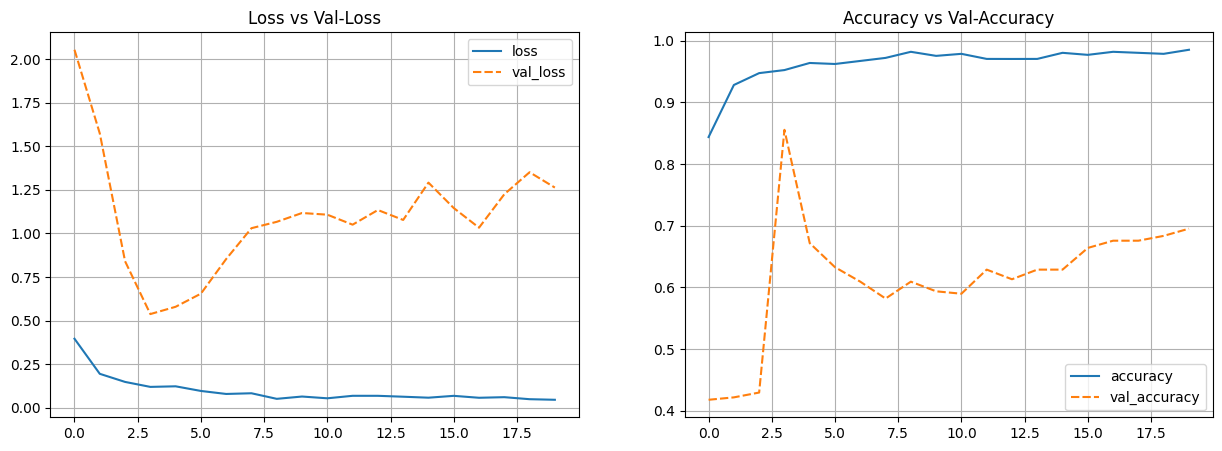

In [34]:
# Plot training results

history_improve = pd.DataFrame(history_improve.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_improve[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_improve[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show

In [35]:
num_test_samples = 208  # example value, adjust as needed
batch_size = 64

# Calculate test steps with ceiling to cover all samples
test_steps = math.ceil(num_test_samples / batch_size)

# Predict using the model, capturing all test samples
predictions = model_improve.predict(test_cmyk, steps=test_steps)

# Convert predictions to binary or multiclass labels
predicted_labels = (predictions > 0.5).astype(int)

# Gather true labels, matching the number of predictions
true_labels = []
for _, label in test_cmyk:
    true_labels.extend(label if label.ndim == 1 else np.argmax(label, axis=1))
    if len(true_labels) >= len(predicted_labels):  # Stop once we match the number of predictions
        true_labels = true_labels[:len(predicted_labels)]  # Trim to match predictions
        break

# Convert true_labels to a numpy array
true_labels = np.array(true_labels)

# Generate the classification report
print(classification_report(true_labels, predicted_labels, target_names=['bad','good']))

4/4 [==============================] - 2s 438ms/step
              precision    recall  f1-score   support

         bad       0.45      0.18      0.25        96
        good       0.54      0.81      0.65       112

    accuracy                           0.52       208
   macro avg       0.49      0.49      0.45       208
weighted avg       0.49      0.52      0.46       208



<h4>Evaluation Improvement Model</h4>

1. Model training is conducted for 20 epochs with a batch size of 64. It specifies how many steps (batches) to run per epoch based on the previously calculated value and indicates how many steps to run for validation, taking approximately 17.5 seconds per epoch.

2. Analyzing the graph, the training results show a significant difference between training accuracy and validation accuracy, as well as a notable disparity in loss scores.

3. The model appears to be overfitting; its performance on the test set is significantly lower, with an accuracy score of 0.55.

4. The model shows an improvement of 1% in accuracy, even though it takes significantly longer per epoch than before the improvement.

### Evaluation Transfer Learning

<function matplotlib.pyplot.show(close=None, block=None)>

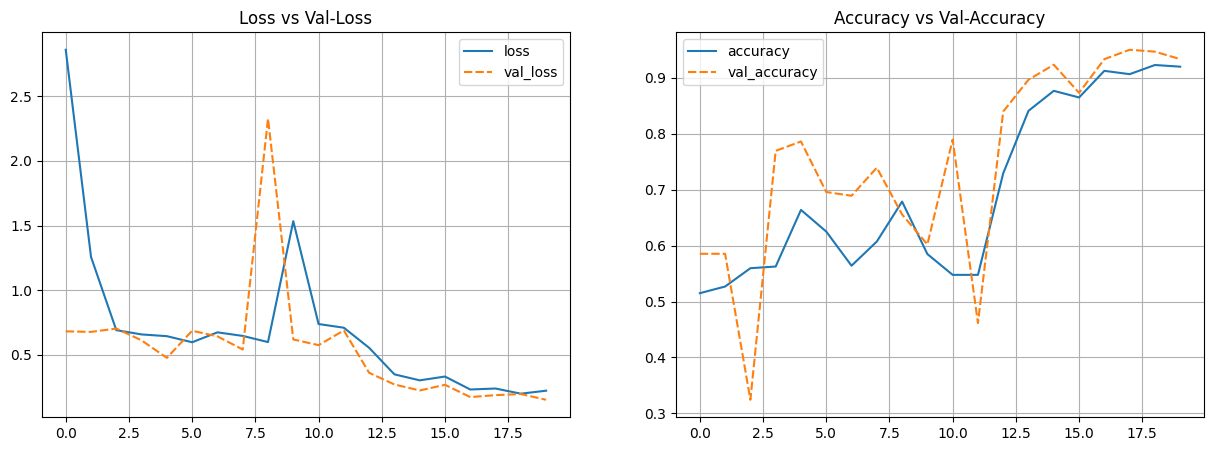

In [36]:
# Plot training results

history_tl = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_tl[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show

In [37]:
# Get the probability of the positive class
y_pred_prob_tl = model_tl.predict(test)

# Apply threshold to convert probabilities to binary class labels (0 or 1)
y_pred_class_tl = (y_pred_prob_tl > 0.5).astype(int)

# Display Classification Report
print(classification_report(test.classes, y_pred_class_tl, target_names=np.array(list(train.class_indices.keys()))))

4/4 [==============================] - 5s 2s/step
              precision    recall  f1-score   support

         bad       0.48      0.46      0.47       101
        good       0.51      0.53      0.52       107

    accuracy                           0.50       208
   macro avg       0.49      0.49      0.49       208
weighted avg       0.49      0.50      0.49       208



<h4>Evaluation Transfer Learning Model</h4>

1. Model training is conducted for 20 epochs with a batch size of 10, taking approximately 20 seconds per epoch.

2. The training results show no difference between training and validation accuracy, both achieving 0.95, with losses of 0.12 and 0.13, respectively.

3. The model appears to be overfitting; despite high accuracy on both the training and validation sets, its performance on the test set is significantly lower, with an accuracy score of only 0.51.

4. The model shows no improvement compared to the baseline or improved models; the accuracy on predictions is lower, and the training time is significantly longer.

# Model Saving

In [38]:
model_improve.save('model_improve.h5')